In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as ss
import time
import pandas as pd
from abc import ABC, abstractmethod
from scipy.optimize import newton

### Utility functions

In [2]:
def plot_diffusion(t, data, title, y_label, x_label):
    
    plt.figure(figsize=(12, 6))
    #t = np.linspace(0, data.shape[1] - 1, data.shape[1])

    plt.plot(t, data[:20].T, alpha=0.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    plt.tight_layout()
    plt.show()

def plot_results(t, MtM_values, EE_values, MtM_title, EE_title, y_label1, y_label2):
    
    plt.figure(figsize=(12, 6))
    #t = np.linspace(0, MtM_values.shape[1] - 1, MtM_values.shape[1])

    plt.subplot(1, 2, 1)
    plt.plot(t, MtM_values[:20].T, alpha=0.5)
    plt.title(MtM_title)
    plt.xlabel('Time')
    plt.ylabel(y_label1)

    plt.subplot(1, 2, 2)
    plt.plot(t, EE_values, color='blue')
    plt.title(EE_title)
    plt.xlabel('Time')
    plt.ylabel(y_label2)

    plt.tight_layout()
    plt.show()

### Create two classes to generate interest rate diffusions using short rate model CIR / Vacisek 

In [3]:
class ProcessDiffusion(ABC):
    @abstractmethod
    def generate_path(self,Paths, Steps, Maturity):
        pass
    @abstractmethod
    def Plot_Diffusion(self, Paths, Steps, Maturity):
        pass
    
class CIRProcess(ProcessDiffusion):
    def __init__(self, r0, sigma, kappa, theta):
        
        self.r0 = r0      
        self.sigma = sigma
        self.kappa = kappa
        self.theta = theta
        
        if 2*self.kappa*self.theta < self.sigma**2 : 
            raise Exception(" Feller condition is not verified")
        
    def generate_path(self, Paths, Steps, Maturity):
        dt = Maturity/Steps
        R  = np.zeros((Paths, Steps))
        R[:, 0] = self.r0
        DW = np.random.randn(Paths, Steps) * np.sqrt(dt)
        for i in range(1, Steps):
            R[:, i] = ((1 - self.kappa*dt/2) * np.sqrt(R[:, i-1]) + self.sigma*DW[:, i-1]/(2 * (1 - self.kappa*dt/2))) ** 2 + (self.kappa*self.theta - self.sigma**2/4)*dt
        return R

    def Plot_Diffusion(self, Paths, Steps, Maturity): 
        t = np.linspace(0, Maturity, Steps)
        R = self.generate_path(Paths, Steps, Maturity)
        plot_diffusion(t, R, "Interest rate in CIR framework", "Rt (in %)", "Time t (in years)")


    
class VacisekProcess(ProcessDiffusion):
    def __init__(self, r0, sigma, kappa, theta):
        
        self.r0 = r0
        self.sigma = sigma
        self.kappa = kappa
        self.theta = theta
        
    def generate_path(self, Paths, Steps, Maturity):
        dt = Maturity/Steps
        R  = np.zeros((Paths, Steps))
        R[:, 0] = self.r0
        DW = np.random.randn(Paths, Steps) * np.sqrt(dt)
        for i in range(1,N):
            R[:,i] = R[:,i-1] + self.kappa*(self.theta - R[:,i-1])*dt + self.sigma * np.sqrt(dt) * DW[:,i-1]
        return R

    def Plot_Diffusion(self, Paths, Steps, Maturity): 
        t = np.linspace(0, Maturity, Steps)
        R = self.generate_path(Paths, Steps, Maturity)
        plot_diffusion(t, R, "Interest rate in Vacisek framework", "Rt (in %)", "Time t (in years)")


class RendlemanBratterProcess(ProcessDiffusion):
    pass
    
class SABRProcess(ProcessDiffusion):
    pass
    

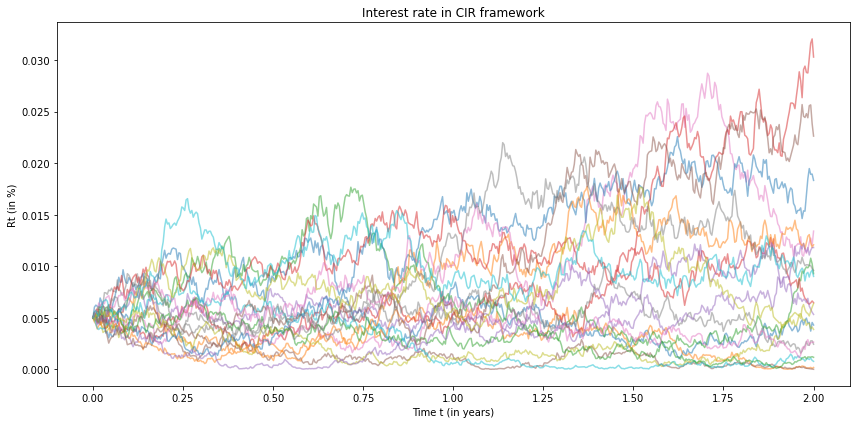

In [5]:
CIR = CIRProcess(0.005, 0.09, 0.3, 0.015)
#CIR = CIRProcess(0.005, 0.09, 0.0003, 0.015) to test feller condition
trading_days, Nmc, T = 252, 100, 2
N = trading_days*T #Discretization: once a day (252 trading days)
CIR.Plot_Diffusion(Nmc, N, T)

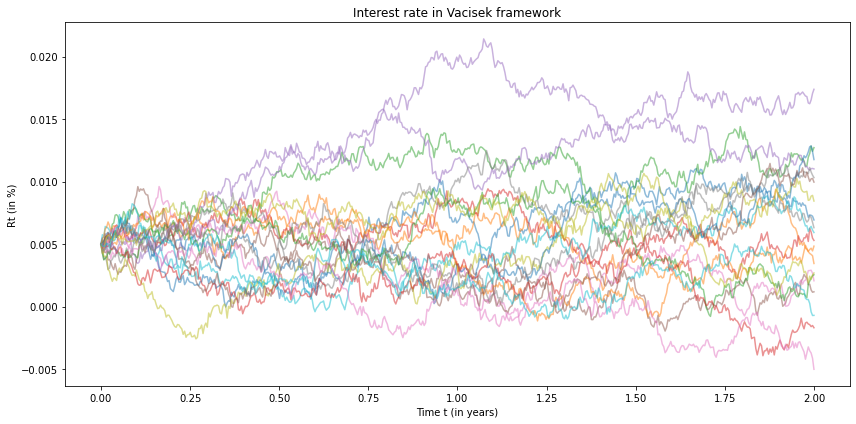

In [6]:
Vacisek = VacisekProcess(0.005, 0.09, 0.3, 0.015)
trading_days, Nmc, T = 252, 100, 2
N = trading_days*T #Discretization: once a day (252 trading days)
Vacisek.Plot_Diffusion(Nmc, N, T)

### Implement Zero Coupon : Solution of Feynman Kac equations in both framework CIR and Vacisek

In [19]:
class ZeroCoupon(ABC):
    @abstractmethod
    def Bond_Price(self, t, T, R):
        pass

class BondCIR(ZeroCoupon):
    
    def __init__(self, sigma, kappa, theta):
        self.kappa = kappa
        self.sigma = sigma
        self.theta = theta 
        
    def Bond_Price(self, t, T, R):
        if t <= T :
            h = np.sqrt(self.kappa**2 + 2*self.sigma**2)
            A = (2 * h * np.exp((self.kappa + h)*(T-t)*0.5) / (2*h + (self.kappa+h)*(np.exp((T-t)*h) - 1)))**(2*self.kappa*self.theta/(self.sigma**2))
            B = 2*(np.exp((T-t)*h) - 1) / (2*h + (self.kappa+h)*(np.exp((T-t)*h) - 1))
            P = A * np.exp( - B * R)   
        else:
            P = 0    
        return P
    
class BondVacisek(ZeroCoupon):
    
    def __init__(self, sigma, kappa, theta):
        self.kappa = kappa
        self.sigma = sigma
        self.theta = theta 
        
    def Bond_Price(self, t, T, R):
        if t <=T :
            B = (1 - np.exp(-self.kappa*(T-t)))/self.kappa
            A = np.exp((self.theta - self.sigma**2/(2*self.kappa**2))*(B-T+t)-self.sigma**2*B**2/(4*self.kappa))
            P = A * np.exp( - B * R)  
        else :
            P = 0
        return P


### Create a Factory Design 

In [20]:
class BondFactory(ABC):
    @abstractmethod
    def Diffusion(self) -> ProcessDiffusion :
        pass
    @abstractmethod
    def BondPrice(self) -> ZeroCoupon :
        pass 

class CIRBond_Diffusion(BondFactory):

    def __init__(self, r0, sigma, kappa, theta):
        self.r0 = r0
        self.sigma = sigma
        self.kappa = kappa
        self.theta = theta
        
    def Diffusion(self) -> ProcessDiffusion :
        return CIRProcess(self.r0, self.sigma, self.kappa, self.theta)
    
    def BondPrice(self) -> ZeroCoupon :
        return BondCIR(self.sigma, self.kappa, self.theta)


class VBond_Diffusion(BondFactory):
    
    def __init__(self, r0, sigma, kappa, theta):
        self.r0 = r0
        self.sigma = sigma
        self.kappa = kappa
        self.theta = theta
        
    def Diffusion(self) -> ProcessDiffusion :
        return VacisekProcess(self.r0, self.sigma, self.kappa, self.theta)
    
    def BondPrice(self) -> ZeroCoupon :
        return BondVacisek(self.sigma, self.kappa, self.theta)  

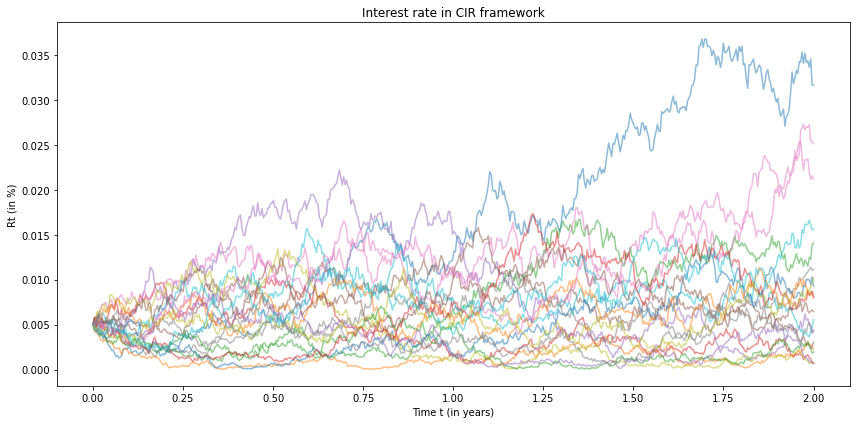

In [21]:
# Test 
trading_days, Nmc, T = 252, 100, 2
N = trading_days*T #Discretization: once a day (252 trading days)
CIRBond_Diffusion(0.005, 0.09, 0.3, 0.015).Diffusion().Plot_Diffusion(Nmc, N, T)

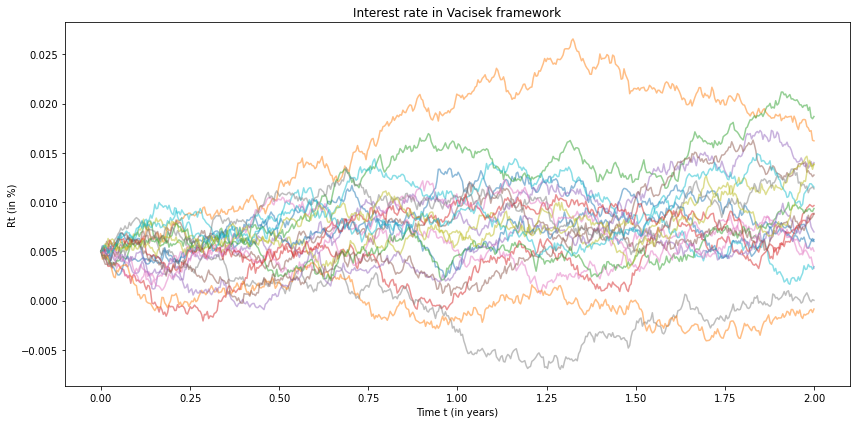

In [22]:
# Test 
trading_days, Nmc, T = 252, 100, 2
N = trading_days*T #Discretization: once a day (252 trading days)
VBond_Diffusion(0.005, 0.09, 0.3, 0.015).Diffusion().Plot_Diffusion(Nmc, N, T)

In [23]:
class read_factory :
    
    def __init__(self, r0, sigma, kappa, theta):
        self.r0 = r0
        self.sigma = sigma
        self.kappa = kappa
        self.theta = theta
        self.factories = {
            "CIR"     : CIRBond_Diffusion(self.r0, self.sigma, self.kappa, self.theta),
            "Vacisek" : VBond_Diffusion(self.r0, self.sigma, self.kappa, self.theta)
        }
    
    def get_factory(self, BondModel):
        if BondModel in self.factories:
            return self.factories[BondModel]
        print(f"Unknown : {BondModel}.")   

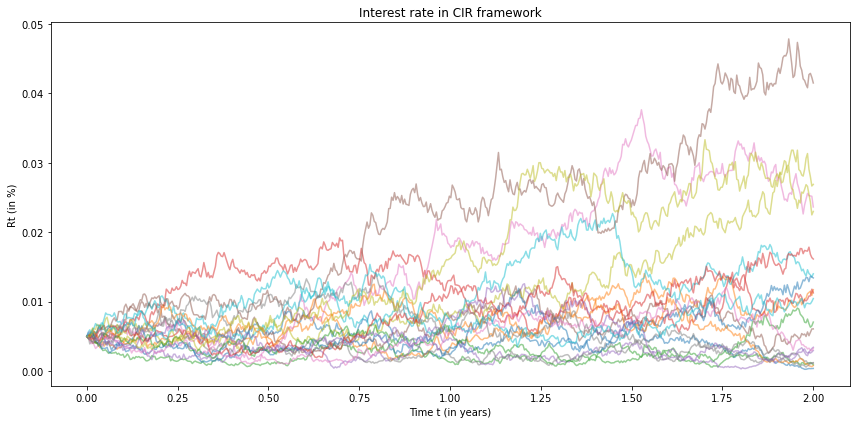

In [24]:
# Test 
trading_days, Nmc, T = 252, 100, 2
N = trading_days*T #Discretization: once a day (252 trading days)
read_factory(0.005, 0.09, 0.3, 0.015).get_factory("CIR").Diffusion().Plot_Diffusion(Nmc, N, T)

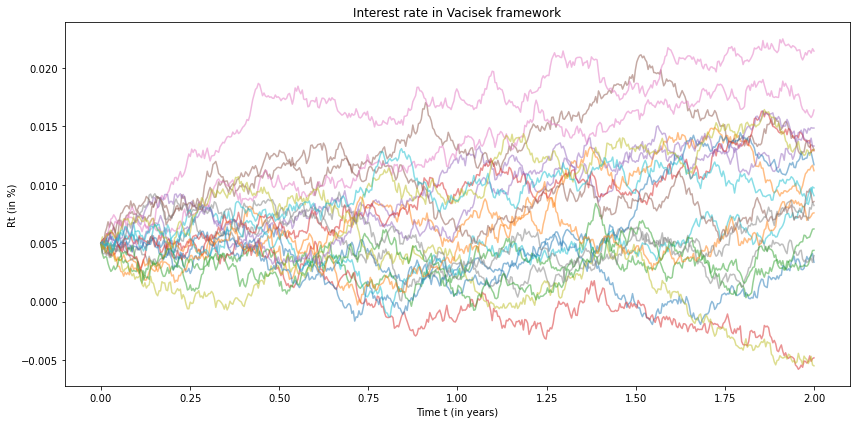

In [25]:
read_factory(0.005, 0.09, 0.3, 0.015).get_factory("Vacisek").Diffusion().Plot_Diffusion(Nmc, N, T)

### Implement Zero Bond matrix for a set of maturities and pricing dates using Strategy Design

In [26]:
class ZeroBond:
    def __init__(self, r0, sigma, kappa, theta, Paths, Steps, Maturity, BondModel):
                
        self.r0 = r0
        self.sigma = sigma
        self.kappa = kappa
        self.theta = theta
        self.Paths = Paths
        self.Steps = Steps
        self.Maturity  = Maturity
        self.BondModel = BondModel
        self.Model = read_factory(self.r0, self.sigma, self.kappa, self.theta).get_factory(self.BondModel)
          
    def BondMatrix(self):
        
        dt = self.Maturity/self.Steps
        t  = np.linspace(0, self.Maturity, self.Steps)
        R  = self.Model.Diffusion().generate_path(self.Paths, self.Steps, self.Maturity)
        T_ = np.linspace(0, self.Maturity, self.Steps)
        P  = np.zeros((self.Paths, self.Steps, self.Steps)) 
        
        for i in range(0, self.Steps):
            for j in range(0, self.Steps):
                P[:, i, j] = self.Model.BondPrice().Bond_Price(t[i], T_[j], R[:, i])
        return P
    
    def Plot_Diffusion(self):
        P = self.BondMatrix()[:,:,-1]
        t = np.linspace(0, self.Maturity, self.Steps)
        plot_diffusion(t, P, "Bond price with maturity " + str(self.Maturity) + "Y-maturity in CIR framework", "P(t, T)", "Time t (in years)")



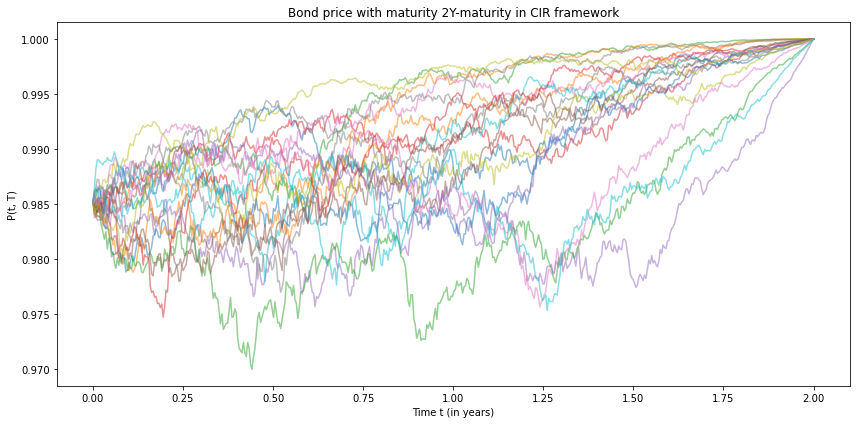

In [27]:
trading_days, Nmc, T = 252, 100, 2
N = trading_days*T #Discretization: once a day (252 trading days)
ZC = ZeroBond(0.005, 0.09, 0.3, 0.015, Nmc, N, T, "CIR")
ZC.Plot_Diffusion()

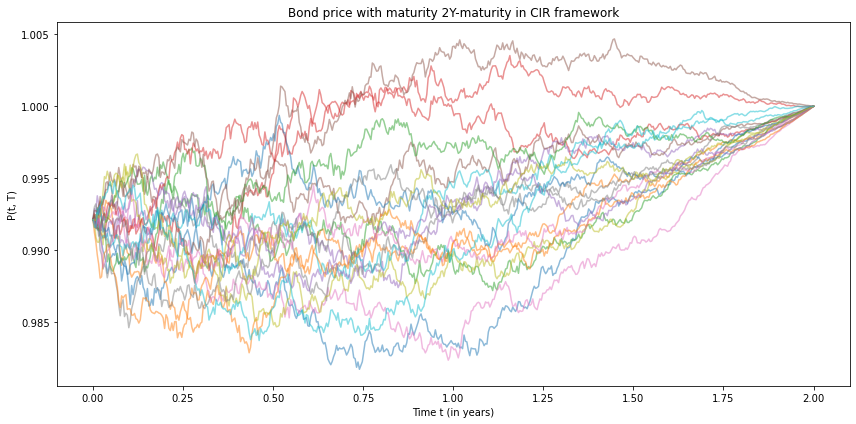

In [28]:
ZC = ZeroBond(0.005, 0.09, 0.3, 0.015, Nmc, N, T, "Vacisek")
ZC.Plot_Diffusion()

### Pricing of an Interest Rates Swap : Projection of expected Mark-to-Market / Strategy Design

In [101]:
class InterestRateSwap:
    
    def __init__(self, r0, sigma, kappa, theta, Paths, Steps, Maturity, BondModel,freq_payments, nominal):
        
        self.r0 = r0
        self.sigma = sigma
        self.kappa = kappa
        self.theta = theta
        self.Paths = Paths
        self.Steps = Steps
        self.Maturity = Maturity
        self.BondModel = BondModel
        self.ZBondMatrix = ZeroBond(self.r0, self.sigma, self.kappa, self.theta, self.Paths, self.Steps, self.Maturity, self.BondModel).BondMatrix()
        self.freq_payments = freq_payments
        self.nominal = nominal
        self.nbr_payments = self.freq_payments*self.Maturity
        self.payment = self.Steps/self.nbr_payments 
        self.year_frac = self.Maturity/self.nbr_payments
   
    def swap_rate(self):
    
        somme = np.zeros(int(self.nbr_payments))
        P = self.ZBondMatrix      
        for j in range(0, self.nbr_payments):
            somme[j] += P[0, 0, int(self.payment)*(j+1) - 1]
        return (P[0, 0, 0] - P[0, 0, -1])/(self.year_frac*sum(somme))
    
    def swap_MtM(self):
        
        swap_value = np.zeros((self.Paths, self.Steps))   
        i = 0
        j = int(self.payment*(i+1)-1)
        paymt = 0
        P = self.ZBondMatrix
        s_rate = self.swap_rate()

        while i < self.Steps and j <= self.Steps:
            while i<j:
                for n in range(0, self.Paths):
                    som = [P[n, i, int(self.payment)*(l+1) - 1] for l in range(paymt, self.nbr_payments)]
                    swap_value[n, i] = self.nominal * (P[n, i, j] - P[n, i, -1] - self.year_frac*s_rate*np.sum(som, axis=0))
                i = i + 1
            i = j
            j = j + int(self.payment)
            paymt = paymt + 1
            
        return swap_value
    
    def swap_Exposure(self):
        return np.mean(np.maximum(0,self.swap_MtM()), axis = 0)
      
    def Plot_Results(self):
        t = np.linspace(0, self.Maturity, self.Steps)
        s_value = self.swap_MtM()
        EE = self.swap_Exposure()
        plot_results(t, s_value, EE , "Mark to Market Swap", "Expected Exposure Profil", "Swap value", "Exposure")

In [115]:
trading_days, Nmc, T = 252, 100, 2
N = trading_days*T #Discretization: once a day (252 trading days)
IRS = InterestRateSwap(0.05, 0.09, 0.3, 0.015, Nmc, N, T, "CIR", 4, 10000)

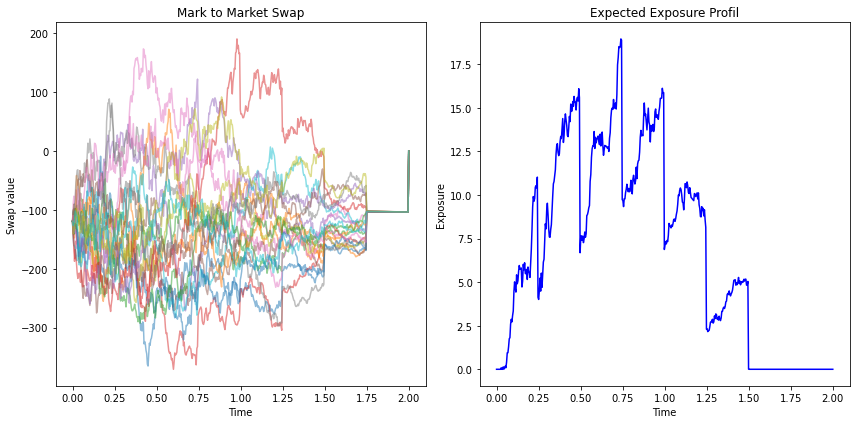

In [116]:
IRS.Plot_Results()

### Compute the CVA using a linear interpolation for Survival probabilities / Strategy Design

In [117]:
class SWAP_CVA :
    
    def __init__(self, r0, sigma, kappa, theta, Paths, Steps, Maturity, BondModel,freq_payments, nominal, LGD):
        self.r0 = r0
        self.sigma = sigma
        self.kappa = kappa
        self.theta = theta
        self.Paths = Paths
        self.Steps = Steps
        self.Maturity = Maturity
        self.BondModel = BondModel
        self.freq_payments = freq_payments
        self.nominal = nominal
        self.LGD = LGD
        self.ZBondMatrix = ZeroBond(self.r0, self.sigma, self.kappa, self.theta, self.Paths, self.Steps, self.Maturity, self.BondModel)
        self.swap = InterestRateSwap(self.r0, self.sigma, self.kappa, self.theta, self.Paths, self.Steps, self.Maturity, self.BondModel,self.freq_payments, self.nominal)
    
    def get_DiscountFactor(self):
        return self.ZBondMatrix.BondMatrix()[0,0,:]
    
    def get_ExpectedExposure(self):
        return self.swap.swap_Exposure()
    
    def get_SurvivalProb(self, spreads = [52, 60]):
        #Interpolation from spreads at 1Y & 2Y and at maturity
        a = (spreads[1] - spreads[0])/(self.Maturity-1)
        b = spreads[1] - a*self.Maturity
        t = np.linspace(0, self.Maturity, self.Steps)
        one_bp_in_unit = 10000
        spread = [a*step*self.Maturity/self.Steps + b for step in range(0, self.Steps)] #trendline from CDS spread quotations
        PS = [np.exp(-spread[step]*t[step]/(self.LGD*one_bp_in_unit)) for step in range(0, self.Steps)]
        return PS
    
    def Compute_CVA(self):
        Vec_CVA = np.zeros(self.Steps)
        EPE = self.get_ExpectedExposure()
        DF  = self.get_DiscountFactor()
        PS  = self.get_SurvivalProb()
        for step in range(0, self.Steps-1):
            Vec_CVA[step+1] = DF[step+1]*EPE[step+1] * np.maximum(0, PS[step] - PS[step+1])         
        return  self.LGD * sum(Vec_CVA)     

In [118]:
trading_days, Nmc, T = 252, 100, 2
N = trading_days*T
SWAP_CVA(0.05, 0.09, 0.3, 0.015, Nmc, N, T, "CIR", 4, 10000, 0.6).Compute_CVA()

0.07984216110510474

### Boostrapping survival probabilities from CDS spreads

####  Implementation of a class of functions for interpolation / extrapolation of discounting factor and survival probabilities

In [125]:
class Functions: 
    
    def __init__(self, yieldcurveTenor, yieldcurveRate, creditcurveTenor, creditcurveSP):
        
        self.yieldcurveTenor  = yieldcurveTenor
        self.creditcurveTenor = creditcurveTenor
        self.yieldcurveRate   = yieldcurveRate
        self.creditcurveSP    = creditcurveSP
        
    def DiscountFactor(self, t):
        result = -1
        min_time_index = 0
        max_time_index = len(self.yieldcurveTenor) - 1

        if t < 0:
            result = - 1
        elif t == 0:
            result = 1.0
        elif t > 0 and t <= self.yieldcurveTenor[min_time_index]:
            result = np.exp(-t*self.yieldcurveRate[0])
        elif t >= self.yieldcurveTenor[max_time_index]:
            result = np.exp(-t*self.yieldcurveRate[-1])
        else:
            for i in range(max_time_index):
                if t >= self.yieldcurveTenor[i] and t < self.yieldcurveTenor[i+1]:
                    yield_interpolated = self.yieldcurveRate[i] + (self.yieldcurveRate[i+1] - self.yieldcurveRate[i]) / \
                    (self.yieldcurveTenor[i+1]-self.yieldcurveTenor[i]) * (t-self.yieldcurveTenor[i])
                    result = np.exp(-t*yield_interpolated)
        return result
    
    def SurvivalProbability(self, t):
        result = -1
        min_time_index = 0
        max_time_index = len(self.creditcurveTenor) - 1
        if t < 0:
            result = -1
        elif t == 0:
            result = 1
        elif t > 0 and t <= self.creditcurveTenor[min_time_index]:
            h = -np.log(self.creditcurveSP[0] / self.creditcurveTenor[min_time_index])
            result = np.exp(-h*t)
        elif t == self.creditcurveTenor[max_time_index]:
            result = self.creditcurveSP[-1]
        elif t > self.creditcurveTenor[max_time_index]:
            h = 0
            if len(self.creditcurveTenor) == 1:
                h = - np.log(self.creditcurveSP[-1]) / self.creditcurveTenor[max_time_index]
            else: 
                h = - np.log(self.creditcurveSP[-1]/self.creditcurveSP[-2]) / \
                        (self.creditcurveTenor[-1]-self.creditcurveTenor[-2])
                result = self.creditcurveSP[-1] * np.exp(-(t - self.creditcurveTenor[max_time_index])*h)
        else: 
            for i in range(max_time_index):
                if t >= self.creditcurveTenor[i] and t < self.creditcurveTenor[i+1]:
                    h = -np.log(self.creditcurveSP[i+1]/self.creditcurveSP[i]) / \
                        (self.creditcurveTenor[i+1]-self.creditcurveTenor[i])
                    result = self.creditcurveSP[i] * \
                        np.exp(-(t-self.creditcurveTenor[i])*h)
        return result


#### Valuation of Premuim and Protection legs for CDS

In [126]:
class CDS:
    
    def __init__(self, creditcurveTenor, creditcurveSP, yieldcurveTenor, yieldcurveRate, cdsMaturity,\
                 num_default_year, num_premium_year, accruedPremiumFlag, spread, recoveryRate):
        
        self.yieldcurveTenor    = yieldcurveTenor
        self.creditcurveTenor   = creditcurveTenor
        self.yieldcurveRate     = yieldcurveRate
        self.creditcurveSP      = creditcurveSP
        self.num_default_year   = num_default_year
        self.num_premium_year   = num_premium_year
        self.cdsMaturity        = cdsMaturity
        self.accruedPremiumFlag = accruedPremiumFlag
        self.spread             = spread
        self.recoveryRate       = recoveryRate
        self.get = Functions(self.yieldcurveTenor, self.yieldcurveRate, self.creditcurveTenor, self.creditcurveSP)
    
    def calculatePremiumLeg(self, h):
        max_time_index = len(self.creditcurveTenor) - 1
        if max_time_index > 0 and self.cdsMaturity <= self.creditcurveTenor[max_time_index]:
                annuity = 0
                accruedPremium = 0
                N = int(self.cdsMaturity*self.num_premium_year)
                for n in range(1, N+1):
                    tn = n / self.num_premium_year
                    tnm1 = (n-1) / self.num_premium_year
                    dt = 1.0 / self.num_premium_year
                    annuity += dt * \
                        self.get.DiscountFactor(tn)*self.get.SurvivalProbability(tn)
                    if accruedPremiumFlag:
                        accruedPremium += 0.5*dt*self.get.DiscountFactor(tn)*(
                            self.get.SurvivalProbability(tnm1) - self.get.SurvivalProbability(tn))
                return spread*(annuity+accruedPremium)
        else:  # When the cds maturity is beyond our current credit curve, we need to estimate the survival probability for payment beyond credit curve
            annuity = 0
            accruedPremium = 0
            N = int(self.cdsMaturity*self.num_premium_year)
            M = self.creditcurveTenor[max_time_index] * self.num_premium_year if max_time_index > 0 else 0

            for n in range(1, N+1):
                if n <= M:
                    tn = n/self.num_premium_year
                    tnm1 = (n-1)/self.num_premium_year
                    dt = 1.0 / self.num_premium_year

                    annuity += dt * self.get.DiscountFactor(tn) * self.get.SurvivalProbability(tn)
                    if(self.accruedPremiumFlag):
                        accruedPremium += 0.5*dt*self.get.DiscountFactor(tn)*(
                            self.get.SurvivalProbability(tnm1) - self.get.SurvivalProbability(tn))
                else:
                    tn = n/self.num_premium_year
                    tnm1 = (n-1)/self.num_premium_year
                    tM = M / self.num_premium_year
                    dt = 1.0 / self.num_premium_year

                    survivalProbability_n = self.get.SurvivalProbability(tM) * np.exp(-h*(tn - tM))
                    survivalProbability_nm1 = 0
                    if tnm1 <= tM:
                        survivalProbability_nm1 = self.get.SurvivalProbability(tnm1)
                    else:
                        survivalProbability_nm1 = self.get.SurvivalProbability(tM)* np.exp(-h*(tnm1 - tM))

                    annuity += dt * self.get.DiscountFactor(tn)*survivalProbability_n
                    if self.accruedPremiumFlag:
                        accruedPremium += 0.5*dt * self.get.DiscountFactor(tn)*(survivalProbability_nm1-survivalProbability_n)

            return self.spread*(annuity+accruedPremium)
    
    def calculateDefaultLeg(self,h):
        
        max_time_index = len(self.creditcurveTenor) - 1
        if max_time_index > 0 and self.cdsMaturity <= self.creditcurveTenor[max_time_index]:
            annuity = 0
            N = int(self.cdsMaturity * self.num_default_year)
            for n in range(1, N+1):
                tn = n / self.num_default_year
                tnm1 = (n-1) / self.num_default_year
                annuity += self.get.DiscountFactor(tn)*(
                    self.get.SurvivalProbability(tnm1) - self.get.SurvivalProbability(tn))
            return (1-self.recoveryRate)*annuity
        else:  
            annuity = 0
            N = int(self.cdsMaturity*self.num_default_year)
            M = self.creditcurveTenor[max_time_index] * self.num_default_year if max_time_index > 0 else 0

            for n in range(1, N+1):
                if n <= M:
                    tn = n / self.num_default_year
                    tnm1 = (n-1) / self.num_default_year
                    annuity += self.get.DiscountFactor(tn)*(
                        self.get.SurvivalProbability(tnm1) - self.get.SurvivalProbability(tn))
                else:  
                    tM = M / self.num_default_year
                    tn = n / self.num_default_year
                    tnm1 = (n-1) / self.num_default_year

                    survivalProbability_n = self.get.SurvivalProbability(tM)*np.exp(-h*(tn-tM))
                    if tnm1 <= tM:
                        survivalProbability_nm1 = self.get.SurvivalProbability(tnm1)
                    else:
                        survivalProbability_nm1 = self.get.SurvivalProbability(tM) * np.exp(-h*(tnm1 - tM))
                    annuity += self.get.DiscountFactor(tn) * (survivalProbability_nm1 - survivalProbability_n)

            return (1-self.recoveryRate)*annuity

    
    def objfunFindHazardRate(self, h):
        return self.calculatePremiumLeg(h) - self.calculateDefaultLeg(h)
              

#### Bootsrapping of Survival Probabilities from CDS spreads

In [127]:
class bootstrapCDSspread :
    
    def __init__(self, yieldcurveTenor, yieldcurveRate, cdsTenors, cdsSpreads, premiumFrequency, defaultFrequency,\
                accruedPremium, recoveryRate):
        
        self.yieldcurveTenor  = yieldcurveTenor
        self.yieldcurveRate   = yieldcurveRate
        self.cdsTenors        = cdsTenors
        self.cdsSpreads       = cdsSpreads
        self.premiumFrequency = premiumFrequency
        self.defaultFrequency = defaultFrequency
        self.accruedPremium   = accruedPremium
        self.recoveryRate     = recoveryRate
        
    def InterpolatedSpreads(self,t):
        
        result = -1
        min_time_index = 0
        max_time_index = len(self.cdsTenors) - 1
        if t < 0:
            result = -1
        elif t == 0:
            result = 0.01
        elif t < self.cdsTenors[min_time_index]:
            result = 0.01 + (self.cdsSpreads[1] - self.cdsSpreads[0]) / (self.cdsTenors[1] - self.cdsTenors[0]) * t
        elif t >= self.cdsTenors[max_time_index]:
            result = self.cdsSpreads[max_time_index]
        else: 
            for i in range(max_time_index):
                if t >= self.cdsTenors[i] and t < self.cdsTenors[i+1]:
                    result = self.cdsSpreads[i] + (self.cdsSpreads[i+1] - self.cdsSpreads[i]) / (self.cdsTenors[i+1] - self.cdsTenors[i]) * (t - self.cdsTenors[i])
        return result
           
        
    def bootstrap(self, Steps, Maturity):
        
        cds_Tenors  = np.linspace(0, Maturity, Steps)[1:]
        cds_Spreads = []
        for i in cds_Tenors:
            cds_Spreads.append(self.InterpolatedSpreads(i))
        
        yieldcurveLength = len(self.yieldcurveTenor)
        cdsTenorsLength = len(cds_Tenors)
        newcreditcurveLength = 0
        newcreditcurve = []
        survprob = [None]*cdsTenorsLength
        hazardRate = [None]*cdsTenorsLength
        creditcurveSP = []
        creditcurveTenor = []
        for i in range(cdsTenorsLength):
            cdsMaturity = cds_Tenors[i]
            spread = cds_Spreads[i]
            self.cds = CDS(creditcurveTenor, creditcurveSP, self.yieldcurveTenor, self.yieldcurveRate, cdsMaturity, 
                           self.defaultFrequency, self.premiumFrequency, self.accruedPremium, spread, self.recoveryRate)
            h = newton(self.cds.objfunFindHazardRate, 0.01)
            hazardRate[i] = h
            if i==0:
                survprob[i] = np.exp(-hazardRate[i]*cds_Tenors[i])
            else:
                survprob[i] = survprob[i-1]*np.exp(-hazardRate[i]*(cds_Tenors[i]-cds_Tenors[i-1]))
            creditcurveTenor.append(cds_Tenors[i])
            creditcurveSP.append(survprob[i])
        return [1]+survprob

In [128]:
yieldcurveTenor = [0.5, 1, 2, 3, 4, 5]
yieldcurveRate = [0.01350, 0.01430, 0.0190, 0.02470, 0.02936, 0.03311]
creditcurveTenor = [1, 3, 5, 7]
creditcurveSP = [0.99, 0.98, 0.95, 0.92]
cdsTenors = [1, 2, 3, 4, 5]
cdsSpreads = [0.0110, 0.0120, 0.0130, 0.0140, 0.0150]
premiumFrequency = 4
defaultFrequency = 400
accruedPremium = True
recoveryRate = 0.40

### 2nd implementation of the CVA class using the class bootstrapCDSspread

In [129]:
class SWAP_CVA :
    
    def __init__(self, r0, sigma, kappa, theta, Paths, Steps, Maturity, BondModel,freq_payments, nominal, LGD):
        self.r0 = r0
        self.sigma = sigma
        self.kappa = kappa
        self.theta = theta
        self.Paths = Paths
        self.Steps = Steps
        self.Maturity = Maturity
        self.BondModel = BondModel
        self.freq_payments = freq_payments
        self.nominal = nominal
        self.LGD = LGD
        self.ZBondMatrix = ZeroBond(self.r0, self.sigma, self.kappa, self.theta, self.Paths, self.Steps, self.Maturity, self.BondModel)
        self.swap = InterestRateSwap(self.r0, self.sigma, self.kappa, self.theta, self.Paths, self.Steps, self.Maturity, self.BondModel,self.freq_payments, self.nominal)
        self.Survival_Prob = bootstrapCDSspread(yieldcurveTenor, yieldcurveRate, cdsTenors, cdsSpreads, premiumFrequency, defaultFrequency, accruedPremium, recoveryRate)
    
    
    def get_DiscountFactor(self):
        return self.ZBondMatrix.BondMatrix()[0,0,:]
    
    def get_ExpectedExposure(self):
        return self.swap.swap_Exposure()
    
    def get_SurvivalProb(self):
        return self.Survival_Prob.bootstrap(self.Steps, self.Maturity)
    
    def Compute_CVA(self):
        Vec_CVA = np.zeros(self.Steps)
        EPE = self.get_ExpectedExposure()
        DF  = self.get_DiscountFactor()
        PS  = self.get_SurvivalProb()
        for step in range(0, self.Steps-1):
            Vec_CVA[step+1] = DF[step+1]*EPE[step+1] * np.maximum(0, PS[step] - PS[step+1])         
        return  self.LGD * sum(Vec_CVA)     
      

In [130]:
trading_days, Nmc, T = 252, 100, 2
N = trading_days*T
SWAP_CVA(0.005, 0.09, 0.3, 0.015, Nmc, N, T, "CIR", 4, 10000, 0.6).Compute_CVA()

0.46233312958549155